In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from random import random
from math import *
import sys
np.set_printoptions(threshold=sys.maxsize)


In [3]:
def overlap(c1, c2):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """
    d = np.linalg.norm(c1.center - c2.center)
    r = c1.a
    R = c2.a
    
    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )

In [4]:
class Neuron:
    
    def __init__(self, ei_type):
        x = random()
        y = random()
        self.center = np.array([x, y])
        self.a = random()*0.05
        #self.circle = plt.Circle(self.center, self.a, edgecolor='black', fill=False)
        
        self.r = random()*0.0002
        self.C = random()*0.01
        
        self.k = 0.02
        self.type = ei_type #excitatory == 0, inhibitory == 1
        
    def step(self, x, dt, D):
        return x+dt*D(x, dt)
    
    def rate(self, x, t):
        return 0.2*(0.0001-x)
    
    def r_fire(self, area):
        self.r += 0.5*area
    
    def calcium(self, x, t):
        return -x*0.32
    
    def c_fire(self):
        self.C += 1
    
    def radius(self, x, t):
        return self.k*(0.08-self.C)
    
    def set_k(self, new_k):
        self.k = new_k
    
    def update(self):
        self.a = max(0, self.step(self.a, 1, self.radius))
        self.r = max(0, self.step(self.r, 1, self.rate))
        self.C = max(0, self.step(self.C, 1, self.calcium))
        #self.circle = plt.Circle(self.center, self.a, edgecolor='black', fill=False)


class Network:
    def __init__(self, n, p = 1.0):
        self.proportion_e = p
        self.proportion_i = 1 - self.proportion_e
        e_neurons = np.array([Neuron(0) for i in range(ceil(n*self.proportion_e))])
        i_neurons = np.array([Neuron(1) for i in range(floor(n*self.proportion_i))])
        self.neurons = np.append(e_neurons, i_neurons)
        self.A = np.zeros((n, n))
        self.refr = np.zeros(n)
        
        self.update_area()
    
    def update_area(self):
        for i in range(0, self.neurons.size):
            for j in range(i, self.neurons.size):
                if i == j:
                    pass
                else:
                    temp = overlap(self.neurons[i], self.neurons[j])
                    self.A[i, j] = temp
                    self.A[j, i] = temp
        
    def fire(self):
        count = 0
        for i in range(self.neurons.size):
            n = self.neurons[i]
            if self.refr[i] == 0 and np.random.binomial(1, min(n.r, 1)):
                #print("FIRE", i, n.r)
                self.refr[i] = 20
                count += 1
                n.c_fire()
                for j in range(self.neurons.size):
                    if i != j:
                        if n.type == self.neurons[j].type or n.type == 0: #ee, ii, or ei
                            self.neurons[j].r_fire(self.A[i, j])
                        else:
                            self.neurons[j].r_fire(-self.A[i, j])
        return count
    
    def network_update(self):
        for i in range(self.refr.size):
            if self.refr[i] > 0:
                self.refr[i] -= 1
        
        for n in self.neurons:
            n.update()
        
        c = self.fire()
        self.update_area()
        return c

        
            
    
    

<IPython.core.display.Javascript object>


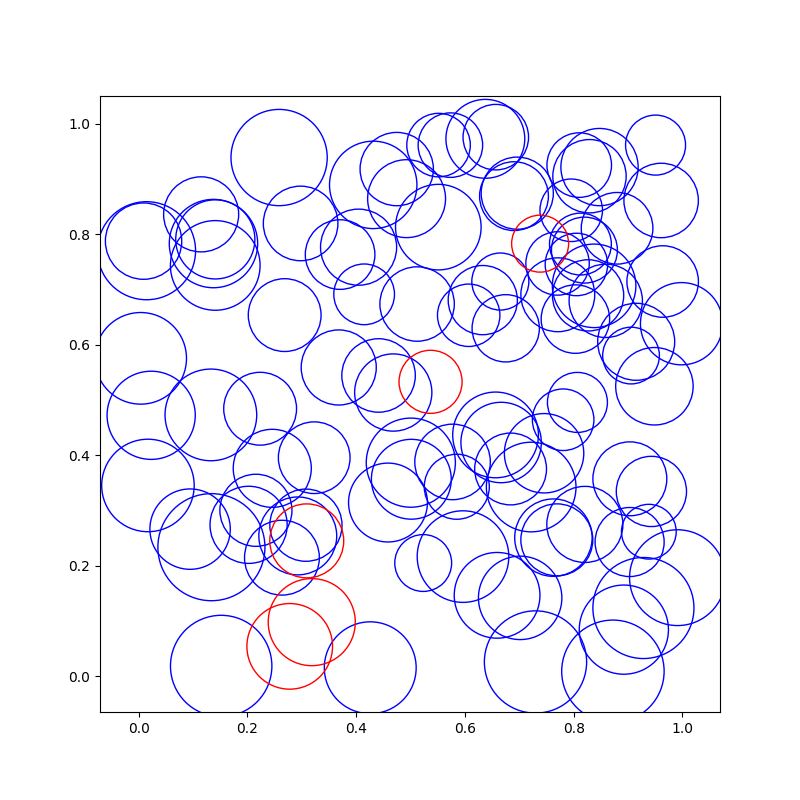

In [5]:
network = Network(100, .95)

e_pos = np.array([n.center for n in (y for y in network.neurons if y.type == 0)])
e_rad = np.array([n.a*17500 for n in (y for y in network.neurons if y.type == 0)])
i_pos = np.array([n.center for n in (y for y in network.neurons if y.type == 1)])
i_rad = np.array([n.a*17500 for n in (y for y in network.neurons if y.type == 1)])

fig, ax = plt.subplots(figsize=(8, 8))
e_scat = ax.scatter(e_pos[:, 0], e_pos[:, 1], s=e_rad, edgecolors='blue', facecolors='none')
i_scat = ax.scatter(i_pos[:, 0], i_pos[:, 1], s=i_rad, edgecolors='red', facecolors='none')
plt.show()

Cs = []
rs = []

def animate(f):
    c = network.network_update()
    Cs.append(network.neurons[0].C)
    rs.append(network.neurons[0].r)
    e_rad = np.array([n.a*17500 for n in (y for y in network.neurons if y.type == 0)])
    i_rad = np.array([n.a*17500 for n in (y for y in network.neurons if y.type == 1)])
    e_scat.set_sizes(e_rad)
    i_scat.set_sizes(i_rad)
        
animation = FuncAnimation(fig, animate, frames=500, interval=1)
plt.show()
animation.save('network-inhibit.gif', writer='imagemagick')

<IPython.core.display.Javascript object>


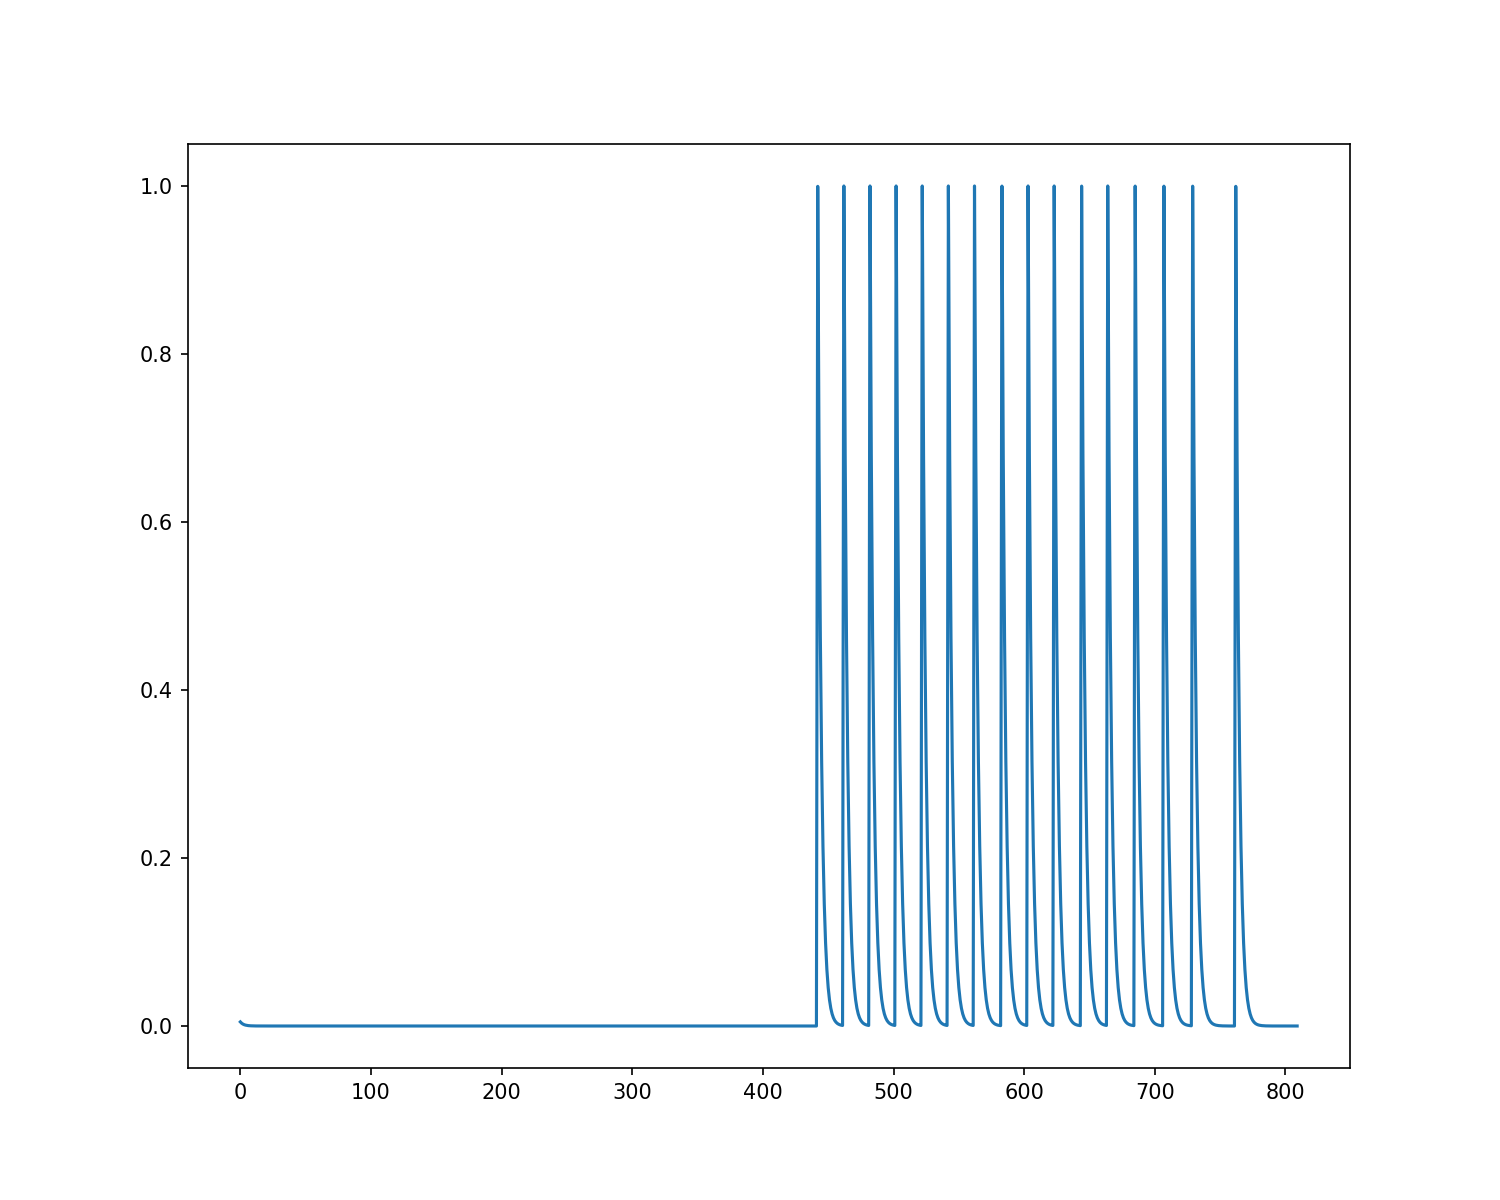

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(Cs)), Cs)
plt.show()

<IPython.core.display.Javascript object>


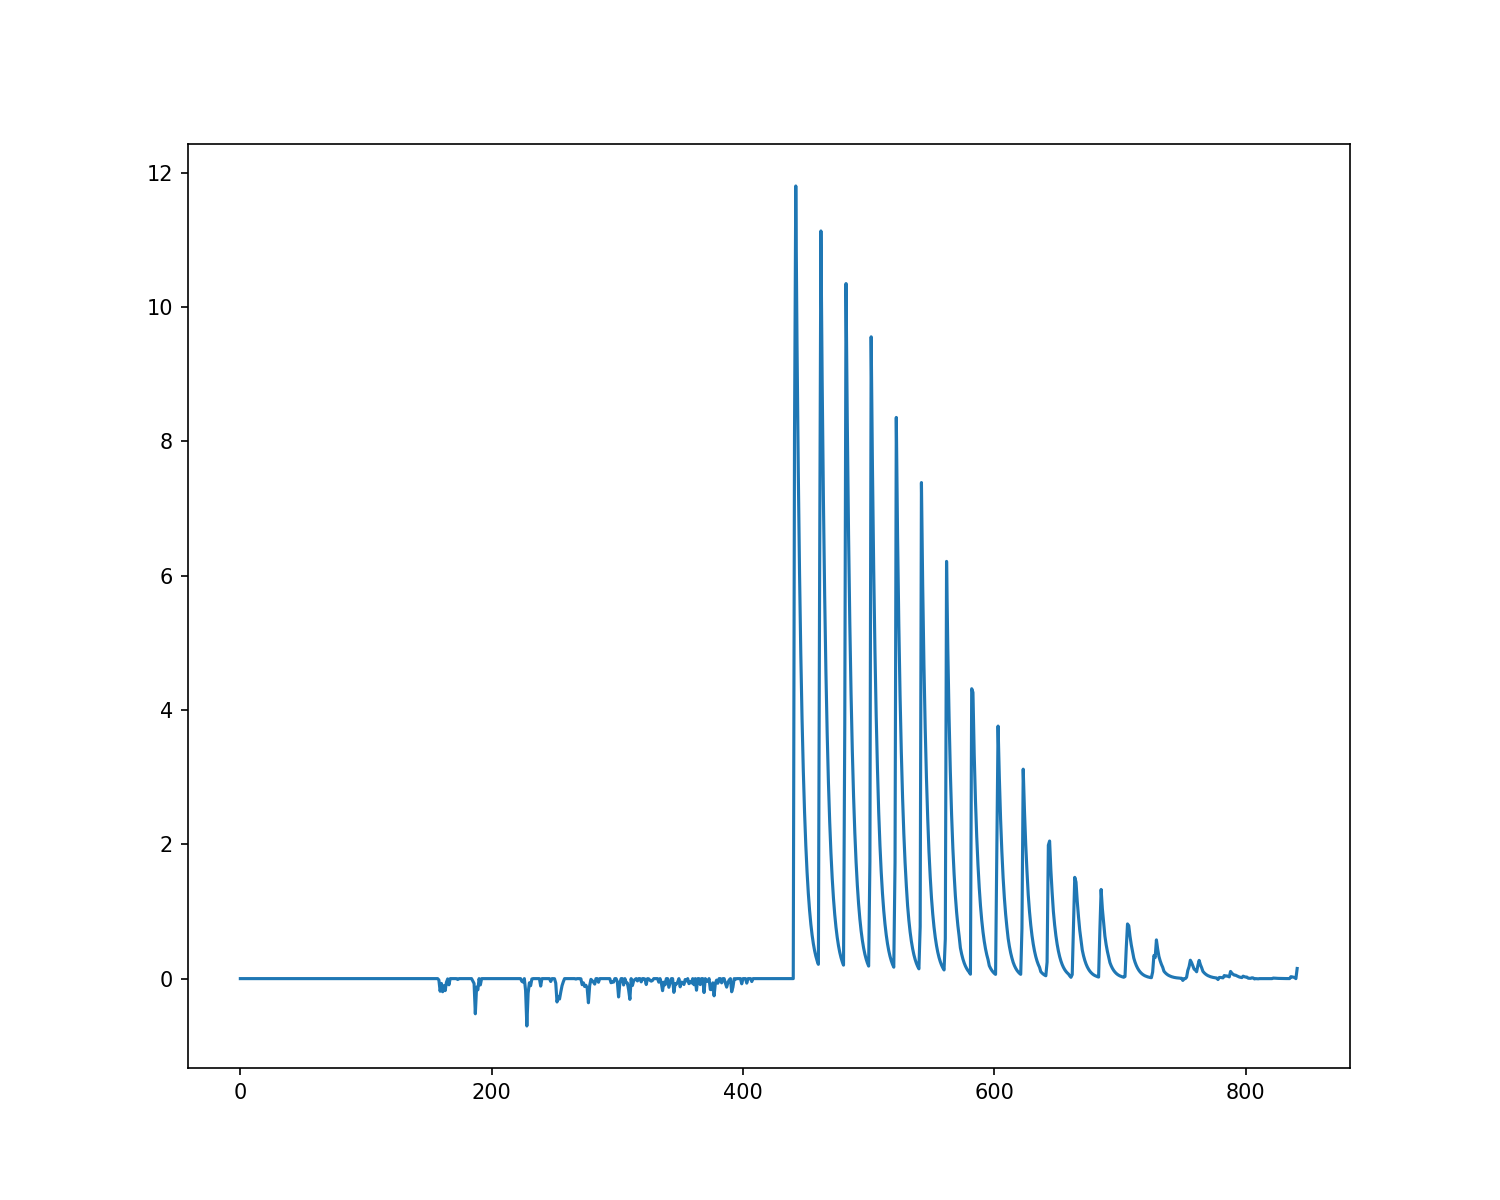

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(rs)), rs)
plt.show()